H23 SETTLED AT: 95.77
m = 4.14%
u = 4.255%

In [101]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import mvn
from scipy.optimize import optimize, brute
from scipy.misc import derivative as prime
from scipy.integrate import quad
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from sklearn import linear_model

mpc = pd.DataFrame({'Date': ['03/23/2023', '05/11/2023', '06/22/2023', '08/03/2023', '09/21/2023', '11/02/2023', '12/14/2023']})
mpc = pd.to_datetime(mpc['Date'])

def _gbs(option_type, fs, x, t, r, b, v):

    t__sqrt = math.sqrt(t)
    d1 = (math.log(fs / x) + (b + (v * v) / 2) * t) / (v * t__sqrt)
    d2 = d1 - v * t__sqrt

    if option_type == "c":
        value = fs * math.exp((b - r) * t) * norm.cdf(d1) - x * math.exp(-r * t) * norm.cdf(d2)
        delta = math.exp((b - r) * t) * norm.cdf(d1)
        gamma = norm.pdf(d1) / (fs * v * t__sqrt)
        theta = -(fs * v * math.exp((b - r) * t) * norm.pdf(d1)) / (2 * t__sqrt) - (b - r) * fs * math.exp((b - r) * t) * norm.cdf(d1) - r * x * math.exp(-r * t) * norm.cdf(d2)
        vega = math.exp((b - r) * t) * fs * t__sqrt * norm.pdf(d1)
        rho = x * t * math.exp(-r * t) * norm.cdf(d2)

    else:
        value = x * math.exp(-r * t) * norm.cdf(-d2) - (fs * math.exp((b - r) * t) * norm.cdf(-d1))
        delta = math.exp((b - r) * t) * norm.cdf(-d1)
        gamma = math.exp((b - r) * t) * norm.pdf(d1) / (fs * v * t__sqrt)
        theta = (fs * v * math.exp((b - r) * t) * norm.pdf(d1)) / (2 * t__sqrt) + (b - r) * fs * math.exp((b - r) * t) * norm.cdf(-d1) + r * x * math.exp(-r * t) * norm.cdf(-d2)
        vega = math.exp((b - r) * t) * fs * t__sqrt * norm.pdf(d1)
        rho = -x * t * math.exp(-r * t) * norm.cdf(-d2)

    return value, delta, gamma, theta, vega, rho


def black_76(option_type, fs, x, t, r, v):
    b = 0
    return _gbs(option_type, fs, x, t, r, b, v)


def _gbs_O(option_type, fs, x, t, r, b, v):

    t__sqrt = math.sqrt(t)
    d1 = (math.log(fs / x) + (b + (v * v) / 2) * t) / (v * t__sqrt)
    d2 = d1 - v * t__sqrt

    if option_type == "c":
        value = fs * math.exp((b - r) * t) * norm.cdf(d1) - x * math.exp(-r * t) * norm.cdf(d2)

    else:
        value = x * math.exp(-r * t) * norm.cdf(-d2) - (fs * math.exp((b - r) * t) * norm.cdf(-d1))
        

    return value


def black_76_O(v,obs_price,option_type, fs, x, t, r):
    b = 0
    return _gbs_O(option_type, fs, x, t, r, b, v) - obs_price


def _gbs_BL(x, fs, t, r, b, v):
    t__sqrt = math.sqrt(t)
    d1 = (math.log(fs / x) + (b + (v * v) / 2) * t) / (v * t__sqrt)
    d2 = d1 - v * t__sqrt
    value = fs * math.exp((b - r) * t) * norm.cdf(d1) - x * math.exp(-r * t) * norm.cdf(d2)
    return value

def black_76_BL(x, fs, t, r, v):
    b = 0
    return _gbs_BL(x, fs, t, r, 0, v)


def bisection_search(obs_price,option_type, fs, x, t, r):
    upper = 1
    lower = 0
    tol = 1e-3
    error = 1
    prev_error = None
    counter = 0
    while error > tol:
        counter +=1
        i = (upper + lower) / 2
        error = black_76_O(i,obs_price,option_type, fs, x, t, r)
        if error > 0:
            upper = i
        else:
            lower = i
        
        prev_error = error 
        error = abs(error)
    return i
    

def IV(alpha, delta):
    a = np.array(alpha)
    d = np.array([delta] * 5 + [abs(0.5 - delta)]) ** np.array([0,1,2,3,4,4])
    return np.sum(a*d)

def implied_strike(delta,fs,t,r,v):
    var = v * v * t
    a = math.sqrt(var)
    b = var/2
    d = norm.ppf(math.exp(r * t) * delta)
    return fs * math.exp(b - (a*d))

def breeden_litzenberger(x, fs, t, r, v):
    return math.exp(r*t)*prime(black_76_BL,dx = 0.001,x0 = x,n=2,args=(fs,t,r,v))



def produce_IV_estimates(chain, asof, r, penalty, return_what='estimates' ):
    path = f'C:/Users/rfield/Desktop/option_implied_distributions/{chain.lower()}_{asof}.xlsx'
    des  = pd.read_excel(path).values[1,0]
    calls = pd.DataFrame(pd.read_excel(path).values[2:,1:6], columns = ['X','B','O','c','iv']).drop(columns = ['B','O']).astype(float)
    puts = pd.DataFrame(pd.read_excel(path).values[2:,8:13], columns = ['X','B','O','p','iv']).drop(columns = ['B','O']).astype(float)
    calls_o = calls[calls['c']>0].index
    puts_o = puts[puts['p']>0].index
    m,d,y = int(des.split('/')[0][-1]), int(des.split('/')[1]),2000 + int(des.split('/')[2][:2]) 
    o = dt(int(asof[:4]),int(asof[4:6]),int(asof[6:]))
    days = (dt(y,m,d) - dt(o.year,o.month,o.day)).days 
    F = float(des.split()[-1])
    t = days / 365
    r /=100
    for i in calls_o:
        try:
            vol = bisection_search(calls.c[i],'c',F,calls.X[i],t,r)
        except ZeroDivisionError:
            vol =0
        calls.iv[i] = vol

    for i in puts_o:
            try:
                vol = bisection_search(puts.p[i],'p',F,puts.X[i],t,r)
            except ZeroDivisionError:
                vol = puts.iv[i-1]
            puts.iv[i] = vol

    for i in calls.index:
        if calls.iv[i] == 0:
            calls.iv[i] = puts.iv[i]

    calls['delta'] = [black_76('c',F,calls.X[i],t,r,calls.iv[i])[1] for i in calls.index]
    puts['delta'] = [black_76('p',F,puts.X[i],t,r,puts.iv[i])[1] for i in puts.index]
    calls = calls[(calls['delta']<0.85)&(calls['delta']>0.15)].copy(deep = True).reset_index(drop = True) 
    puts =  puts[(puts['delta']<0.85)&(puts['delta']>0.15)].copy(deep = True).reset_index(drop = True)
    puts['delta'] = 1 - puts.delta

    data = pd.concat((puts[['iv','delta']],calls[['iv','delta']]),ignore_index=True)
    data['delta_2'] = [i**2 for i in data.delta]
    data['delta_3'] =[i**3 for i in data.delta]
    data['delta_4'] =[i**4 for i in data.delta]
    data['delta_abs'] = [abs(0.5 -i)**4 for i in data.delta]
    
    X = data[['delta','delta_2','delta_3','delta_4','delta_abs']]
    y = data['iv']
    model_2 = linear_model.Ridge(alpha = penalty)
    model_2.fit(X,y)
    fitted_alpha_ridge = [model_2.intercept_] + [i for i in model_2.coef_]
    data['check_r'] = [IV(fitted_alpha_ridge,i) for i in data.delta]
    
    plt.scatter(x = data.delta,y = data.iv,color = 'b')
    plt.scatter(x = data.delta,y = data.check_r,color = 'r')
    
    
    if return_what =='estimates':
        return fitted_alpha_ridge
    else:
        plt.scatter(x = data.delta,y = data.iv,color = 'b')
        plt.scatter(x = data.delta,y = data.check_r,color = 'r')

    
def generate_dist(chain, asof, r ,vol_param):
    path = f'C:/Users/rfield/Desktop/option_implied_distributions/{chain.lower()}_{asof}.xlsx'
    des  = pd.read_excel(path).values[1,0]
    m,d,y = int(des.split('/')[0][-1]), int(des.split('/')[1]),2000 + int(des.split('/')[2][:2]) 
    o = dt(int(asof[:4]),int(asof[4:6]),int(asof[6:]))
    days = (dt(y,m,d) - dt(o.year,o.month,o.day)).days 
    F = float(des.split()[-1])
    t = days / 365
    r /=100
    dist_df = pd.DataFrame({})
    dist_df['delta'] = np.linspace(0.001,0.999,num = 100000)
    dist_df['iv'] = [IV(vol_param,i) for i in dist_df.delta]
    dist_df['x'] = [implied_strike(delta=i,fs=F,t=t,r=r,v=j) for i,j in zip(dist_df.delta,dist_df.iv)]
    dist_df['r'] = [100 - i for i in dist_df.x]
    dist_df['bl'] = [breeden_litzenberger(x=i,fs=F,t=t,r=r,v=j) for i,j in zip(dist_df.x,dist_df.iv)]
    dist_df['dr'] = dist_df['r'].diff()
    dist_df.dropna(inplace = True)
    dist_df.reset_index(inplace = True)
    dist_df_p = np.sum(dist_df.bl.values*dist_df.dr.values)
    dist_df['bl'] = dist_df['bl']/dist_df_p
    dist_df['cum_bl'] = dist_df.bl.values*dist_df.dr.values
    dist_df['cum_bl'] = dist_df['cum_bl'].cumsum()
    
    moments = pd.DataFrame({}, columns = ['AVG','STD','MEDIAN', 'MODE','SKEW','KURTOSIS','NP SKEW'])
    
    moments.loc[0,'AVG'] = np.sum(dist_df.bl.values*dist_df.dr.values*dist_df.r.values)
    moments.loc[0,'STD'] = np.sqrt(np.sum( dist_df.bl.values*dist_df.dr.values*((dist_df.r.values - moments.AVG[0])**2))) 
    moments.loc[0,'SKEW'] = np.sum(dist_df.bl.values*dist_df.dr.values*((dist_df.r.values - moments.AVG[0])**3)) /( moments.STD[0] **3)
    moments.loc[0,'KURTOSIS'] = np.sum( dist_df.bl.values*dist_df.dr.values*((dist_df.r.values - moments.AVG[0])**4)) / (moments.STD[0] ** 4)
    moments.loc[0,'MEDIAN']  = dist_df['r'][dist_df['cum_bl']> 0.5].values[0]
    moments.loc[0,'MODE'] = dist_df[dist_df['bl'] == dist_df['bl'].max()]['r'].values[0]
    return dist_df , moments * 100
    
def plot_dist(df,asof,chain ,color = 'blue'):
    o = dt(int(asof[:4]),int(asof[4:6]),int(asof[6:]))
    fig, ax =  plt.subplots(figsize = (15,6))
    ax.plot(df.r.values,df.bl.values, color = color)
    ax.set_xlabel('RATE')
    ax.set_ylim(ymin=0)
    x = ax.lines[0].get_xydata()[:,0]
    y = ax.lines[0].get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.1)
    ax.set_title(f'OPTION IMPLIED DISTRIBUTION ON {chain} AS OF {o.strftime("%B")} {o.strftime("%d")}'.upper())
    plt.show()


def plot_dist_comp(df,df_old,asof,asof_old,chain ,color = 'blue'):
    o = dt(int(asof[:4]),int(asof[4:6]),int(asof[6:]))
    q = dt(int(asof_old[:4]),int(asof_old[4:6]),int(asof_old[6:]))
    fig, ax =  plt.subplots(figsize = (15,6))
    ax.plot(df.r.values,df.bl.values, color = color,label = o.strftime('%b %d'))
    ax.plot(df_old.r.values,df_old.bl.values, color = f'dark{color}', linestyle = '--',label = q.strftime('%b %d'))
    ax.set_xlabel('RATE')
    ax.set_ylim(ymin=0)
    x = ax.lines[0].get_xydata()[:,0]
    y = ax.lines[0].get_xydata()[:,1]
    ax.legend()
    ax.fill_between(x, y, color=color, alpha=0.1)
    ax.set_title(f'OPTION IMPLIED DISTRIBUTION ON {chain} AS OF {o.strftime("%B")} {o.strftime("%d")}'.upper())
    plt.savefig(f'C:/Users/rfield/Desktop/option_implied_distributions/{chain}_{asof}_RND.png', bbox_inches='tight')
    
    plt.show()    

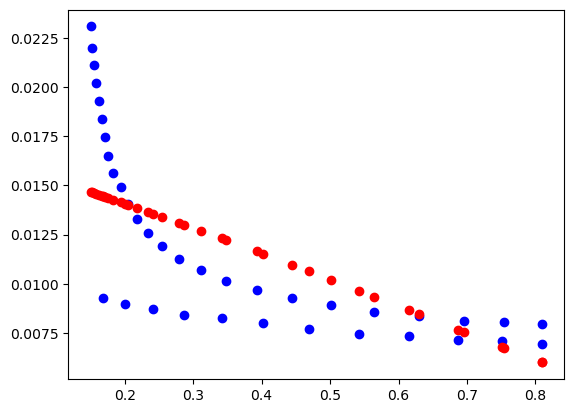

In [102]:
chain = 'sfrm5'
asof_1 = '20240819'
asof = '20240802'
r_1 = 3.66
r = 3.66
penalty = 0.5
x = produce_IV_estimates(chain,asof_1,r_1,penalty)

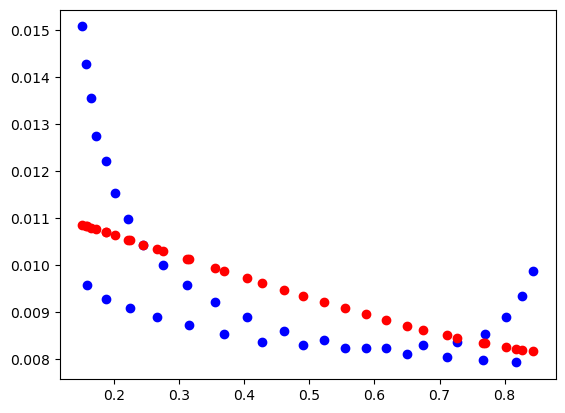

In [103]:
y = produce_IV_estimates(chain,asof,r,penalty)

In [104]:
df, mom = generate_dist(chain, asof,r,y)
df_1, mom_1 = generate_dist(chain, asof_1,r_1,x)
mom.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/{chain}_{asof}_mom10.xlsx')
mom_1.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/{chain}_{asof_1}_mom10.xlsx')

C:\Users\rfield\AppData\Local\Temp\ipykernel_26040\2769423555.py:114: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return math.exp(r*t)*prime(black_76_BL,dx = 0.001,x0 = x,n=2,args=(fs,t,r,v))
C:\Users\rfield\AppData\Local\Temp\ipykernel_26040\2769423555.py:114: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return math.exp(r*t)*prime(black_76_BL,dx = 0.001,x0 = x,n=2,args=(fs,t,r,v))


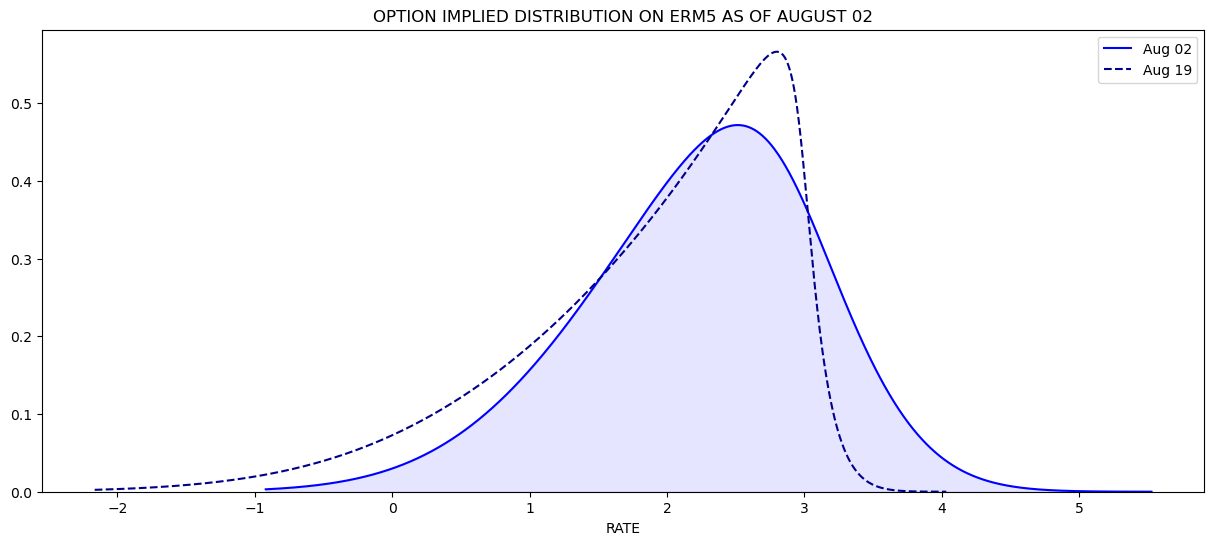

In [105]:
plot_dist_comp(df,df_1,asof,asof_1,chain,color = 'blue')

In [106]:
df.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/2024-08-19/{chain}_{asof_1}_df.xlsx')
df_1.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/2024-08-19/{chain}_{asof}_df.xlsx')

In [59]:
df

,index,delta,iv,x,r,bl,dr,cum_bl
0,1,0.001010,0.029911,105.056928,-5.056928,0.001096,0.008588,0.000009
1,2,0.001020,0.029911,105.048417,-5.048417,0.001106,0.008511,0.000019
2,3,0.001030,0.029911,105.039982,-5.039982,0.001116,0.008435,0.000028
3,4,0.001040,0.029910,105.031622,-5.031622,0.001126,0.008360,0.000038
4,5,0.001050,0.029910,105.023335,-5.023335,0.001137,0.008287,0.000047
...,...,...,...,...,...,...,...,...
95727,95728,0.956375,0.009392,93.386224,6.613776,0.000239,0.039591,0.999968
95728,95729,0.956385,0.009393,93.337135,6.662865,0.000188,0.049089,0.999978
95729,95730,0.956395,0.009393,93.272147,6.727853,0.000136,0.064988,0.999986
95730,95731,0.956405,0.009393,93.174620,6.825380,0.000082,0.097527,0.999994


In [30]:
chain = 'erm5'
asof_1 = '20240813'
asof = '20240813'
r_1 = 3.66
r = 3.66
penalty = 1
x = produce_IV_estimates(chain,asof_1,r_1,penalty)

ValueError: could not convert string to float: 'ERM5C 92'

In [ ]:
y = produce_IV_estimates(chain,asof,r,penalty)

In [ ]:
df, mom = generate_dist(chain, asof,r,y)
df_1, mom_1 = generate_dist(chain, asof_1,r_1,x)
mom.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/{chain}_{asof}_mom10.xlsx')
mom_1.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/{chain}_{asof_1}_mom10.xlsx')

In [ ]:
plot_dist_comp(df,df_1,asof,asof_1,chain,color = 'blue')

In [25]:
df.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/{chain}_{asof_1}_df.xlsx')
df_1.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/{chain}_{asof}_df.xlsx')

In [ ]:
df.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/2024-08-02/{chain}_{asof_1}_df4.xlsx')
df_1.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/2024-08-02/{chain}_{asof}_df4.xlsx')

In [48]:
import pandas as pd
from datetime import datetime, timedelta


# Calculate the range of dates
start_date = datetime.today()
end_date = start_date - timedelta(days=99073)
date_range = pd.date_range(end=start_date, start=end_date)
formatted_dates = [date.strftime('%Y-%m-%d') for date in date_range]

# Add the date column to the dataframe
df['Date'] = date_range

# Print the dataframe
print(df)

       index     delta        iv            x            r            bl  \
0          1  0.001010  0.118650  5244.714977 -5144.714977  7.363728e-06   
1          2  0.001020  0.118650  5243.678609 -5143.678609  7.437289e-06   
2          3  0.001030  0.118650  5242.651728 -5142.651728  7.509159e-06   
3          4  0.001040  0.118651  5241.634156 -5141.634156  7.564964e-06   
4          5  0.001050  0.118651  5240.625720 -5140.625720  7.646135e-06   
...      ...       ...       ...          ...          ...           ...   
99069  99070  0.989728  0.254708  2427.845433 -2327.845433  8.658235e-07   
99070  99071  0.989738  0.254711  2406.456403 -2306.456403  8.658235e-07   
99071  99072  0.989748  0.254715  2378.471354 -2278.471354  8.658235e-07   
99072  99073  0.989758  0.254718  2337.236284 -2237.236284 -8.658235e-07   
99073  99074  0.989768  0.254721  2252.039264 -2152.039264  8.658235e-07   

              dr    cum_bl                       Date  
0       1.046039  0.000008 1752

In [65]:
import win32com.client
import datetime
import pandas as pd

c = win32com.client.Dispatch("Macrobond.Connection")
d = c.Database

from macrobond_api_constants import SeriesFrequency as f
from macrobond_api_constants import SeriesWeekdays as wk

output = df.iloc[90000:, :]
m = d.CreateEmptyMetadata()
dates = output['Date'].dt.to_pydatetime()
values = output[['r','bl']].values
s = d.CreateSeriesObject("ih:mb:priv:s2", "r", "us", "Forecasts", f.DAILY, wk.MONDAY_TO_FRIDAY, dates, values, m)

d.UploadOneOrMoreSeries(s)

output

com_error: (-2147352567, 'Exception occurred.', (0, 'Abacus.ComApi', 'There must be one start date or the same number of dates as values\r\nParameter name: startDateOrDates\r\nActual value was 9074.', None, 0, -2146233086), None)

In [69]:
len(output[['r','bl']].values

9074

In [44]:
import win32com.client
import datetime
import pandas as pd

c = win32com.client.Dispatch("Macrobond.Connection")
d = c.Database

from macrobond_api_constants import SeriesFrequency as f
from macrobond_api_constants import SeriesWeekdays as wk

output = pd.read_excel("C:/Users/rfield/AppData/Local/Microsoft/Windows/INetCache/Content.Outlook/B62ULJV4/output.xlsx")
m = d.CreateEmptyMetadata()
dates = output['Date'].dt.to_pydatetime()
values = output['vix'].to_list()
s = d.CreateSeriesObject("ih:mb:priv:test", "vix", "us", "Forecasts", f.DAILY, wk.MONDAY_TO_FRIDAY, dates, values, m)

d.UploadOneOrMoreSeries(s)


In [ ]:
mom_1


In [ ]:
chain = 'sfim24'
r_1 = 5.265
r = 5.265
penalty = 10
x = produce_IV_estimates(chain,asof_1,r_1,penalty )


In [ ]:
y = produce_IV_estimates(chain,asof,r,penalty)

In [ ]:
df, mom = generate_dist(chain, asof,r,y)
df_1, mom_1 = generate_dist(chain, asof_1,r_1,x)
mom.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/{chain}_{asof}_mom.xlsx')
mom_1.to_excel(f'C:/Users/rfield/Desktop/option_implied_distributions/{chain}_{asof_1}_mom.xlsx')

In [ ]:
plot_dist_comp(df,df_1,asof,asof_1,chain,color = 'green')

In [ ]:
mom


In [ ]:
mom_1


In [ ]:
grid = pd.DataFrame({},index = range(-100,101,25),columns = range(-100,101,25))
path = []
ate = []
for i in range(-100,101,25):
    for j in range(-100,101,25):
        grid.at[i,j] = futures_price('H23',mpc,[3.9275,i/100,j/100])


In [ ]:
grid

In [ ]:
h23 = 100.00 -95.77
h23

In [ ]:
discrete = [df['r'].min()] + [grid['ate'][grid['cum'] == i].mean() for i in grid['cum'].unique()] + [df['r'].max()]
discrete = [(discrete[i]+discrete[i-1])/2 for i in range(1,len(discrete))]

In [ ]:
probs = [prob(discrete[i],df)  - prob(discrete[i-1],df)for i in range(1,len(discrete))]
        

In [ ]:
plt.bar(range(len(probs)),probs)

In [ ]:
probs

In [ ]:
grid['cum'].unique()

In [ ]:
fmc = pd.DataFrame({'Date': ['03/22/2023', '05/03/2023', '06/14/2023', '07/26/2023', '09/20/2023', '11/01/2023', '12/13/2023']})
ecb = pd.DataFrame({'Date': ['03/22/2023', '05/10/2023', '06/21/2023', '08/02/2023', '09/20/2023', '11/01/2023', '12/20/2023']})
mpc = pd.DataFrame({'Date': ['03/23/2023', '05/11/2023', '06/22/2023', '08/03/2023', '09/21/2023', '11/02/2023', '12/14/2023']})

In [ ]:
discrete

In [ ]:
probs

In [ ]:
np.array([1,2,3]) - 2

In [13]:
df.to_excel('Z:/Global strategy team/Personal/Ryan/risk_neutral_option_distributions.xlsx', index=False,sheet_name = f'{chain}{asof}')